# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data


The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating time series data that greatly resembles the one from last week but with some differences.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the previous week.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html). 

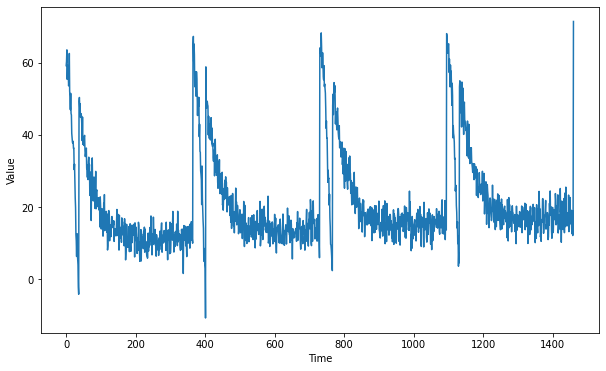

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

In [15]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    # Shuffle it
    dataset = dataset.shuffle(buffer_size=10).map(lambda window:(window[:-1], window[-1]))
    # Split it into the features and labels
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [16]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: False

batch_of_labels is equal to first five labels: False


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True
```

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

In [18]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, input_shape=[window_size]) 
        
    ]) 

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    
    ### END CODE HERE

    return model

In [19]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 8ms/step - loss: 345.3105
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 142.4347
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 132.7466
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 123.4727
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 116.1103
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 109.6031
Epoch 7/100
34/34 [==============================] - 0s 6ms/step - loss: 103.7669
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 98.7322
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 94.0640
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 89.9432
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 86.2313
Epoch 12/100
34/34 [==============================] - 0s 5ms/step - loss: 82.8994
Epoch 13/100
34/34

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [20]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

For this, run the cell below which uses the `generate_forecast` function to compute the forecast. This function generates the next value given a set of the previous `window_size` points for every point in the validation set.

1/1 [==============================] - 0s 24ms/step


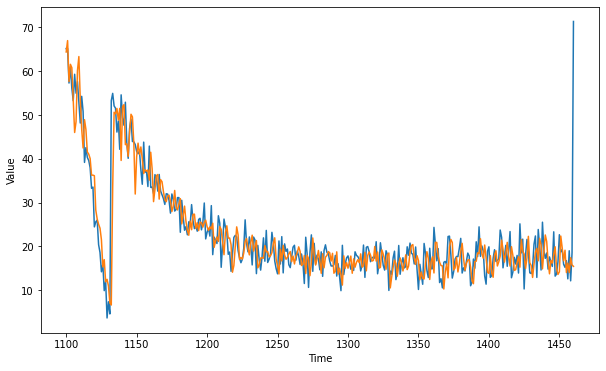

In [22]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/assignment/images/forecast.png?raw=1" width="500"/>
</div>

In [23]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 33.89, mae: 3.65 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a HDF5 file file which will be used for grading and after doing so, submit your assigment for grading.


- Make sure you didn't use `Lambda` layers in your model since these are incompatible with the `HDF5` format which will be used to save your model for grading.


- This environment includes a dummy `my_model.h5` file which is just a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [24]:
# Save your model in HDF5 format
model.save('my_model.h5')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**